## Solutions for the computational experiments in "Homework 1" of Abu-Mostafa's "Learning from Data" Machine Learning online course.

Copyright (C) 2020  Marcelo S. Reis.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.


### Exercise 4.

In [1]:
from random import random
from scipy import stats

mu = 0.55   # Probability of red marble in a single draw
N  = 10     # Sample of ten marbles

dist = stats.binom(N, mu)

# nu = 0 is the probability of getting no red marbles
#
print('Probability of nu = 0 for a single sample: %.7f' % dist.pmf(0))


Probability of nu = 0 for a single sample: 0.0003405


### Exercise 5.

To address this exercise, consider that the probability of at least one of 1000 samples having $\nu = 0$ is equal to one minus the probability of no sample having $\nu = 0$.

The probability of no sample having $\nu = 0$ is equal to $Pr(\nu_1 > 0) Pr(\nu_2 > 0) \ldots Pr(\nu_{1000} > 0)$, where $\nu_i$ is the fraction of red marbles in the $i$-th sample.

Therefore, we can solve the exercise by simply computing $1 - Pr(\nu_1 > 0) Pr(\nu_2 > 0) \ldots Pr(\nu_{1000} > 0)$.

In [2]:
prob = 1 - dist.pmf(0)

final = prob
for i in range(1,1000):      # first term is already in final variable
    final = final * prob

print('Probability of v = 0 for at least one of 1000 samples: %.3f' % (1 - final))


Probability of v = 0 for at least one of 1000 samples: 0.289


### Exercises 7 and 8.

We start defining auxiliary methods to generate a target function and also to draw samples from a domain $\mathcal{X} = [-1,1] \times [-1, 1]$:

In [3]:
from random import randint

# An assistant method for draw of a point in [-1,1]x[-1,1].
#
def draw_point():
    return (random() * (-1) ** randint(0,1), random() * (-1) ** randint(0,1))

# This method returns parameter values for a target function f(x1,x2) = a1 x1 + a2 x2 + b.
#
def generate_target_function():
    point_1 = draw_point()
    point_2 = draw_point()    
    a = (point_1[1] - point_2[1]) / (point_1[0] - point_2[0])
    b = point_1[1] - a * point_1[0]
    return (a, b)

# This method receives a sample size N and parameter values of a target function f. 
# It returns N pairs of observations ((x1,x2),y), where x1 and x2 are values in 
# [-1,1] and y is a value in {-1, +1} defined according whether its corresponding
# (x1,x2) coordinates fall above or below the target function line. 
#
def generate_data(N, a, b):
    D = []
    for _ in range(0,N):
        x1 = random() * (-1) ** randint(0,1)
        x2 = random() * (-1) ** randint(0,1)
        y = +1
        if ( x2 <  (a * x1 + b)):
            y = -1
        D.insert(0,(x1, x2, y))
    return D

Let us test the two methods defined above:

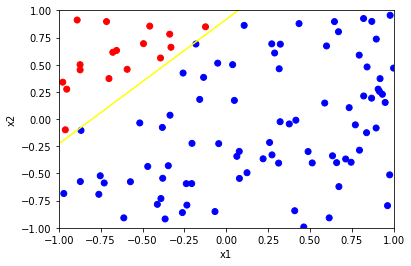

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# This method receives a sample D, parameter values of a function and
# plots a graph in which each point is painted according to its location
# in respect to the function.
#
def plot_sample(D, a, b):
    label_color = []               # +1 and -1 must be painted with 'r' and 'b', respectively.
    for i in range(0,len(D)):
        if D[i][2] == 1:
            label_color.append('r')
        else:
            label_color.append('b')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.scatter(list(zip(*D))[0],list(zip(*D))[1],c=label_color)
    plt.plot(np.linspace(-1, 1, 10), a * np.linspace(-1, 1, 10) + b, c= "yellow")
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

(a, b) = generate_target_function()

D = generate_data(100, a, b)

plot_sample(D, a, b)


Now, we implement a Perceptron Learning Algorithm (PLA) for problems with dimension $d = 2$:

In [5]:
# PLA receives a sample D with N points and returns the estimated weights w0, w1 and w2.
# It also returns the number n of iterations required to finish the procedure.
#
def PLA (D):
    N = len(D)
    w0 = w1 = w2 = n = 0
    misclassified = True
    while (misclassified == True):
        misclassified = False
        for i in range(0,N):
            x1 = D[i][0]
            x2 = D[i][1]
            y  = D[i][2]
            dot_prod = w2 * x2 + w1 * x1 + w0
            if not ( ((y == 1) and (dot_prod > 0)) or ((y == -1) and (dot_prod < 0)) ):
                w2 = w2 + y * x2
                w1 = w1 + y * x1
                w0 = w0 + y * 1
                misclassified = True
                n += 1
    return (w0, w1, w2, n)

Finally, we can run 1000 times an experiment with $N = 10$:

In [6]:
import statistics as stat

# Method that receives the number of runs k and the sample size N of each run.
# For each run, it generates a target function f, draws N samples using it and estimates an approximation
# g of f by applying the sample into PLA. For each run, it also estimates the out-of-sample error.
# Finally, it returns, for each run, the required number of iterations by PLA and also the 
# out-of-sample error of that run.
#
def run_PLA_experiment(k, N):
    
    n_iter = []  # number of iterations of the i-th experiment.

    Eout   = []  # out-of-sample error of the i-th experiment.

    for _ in range(0,k):

        (a, b) = generate_target_function()

        D  = generate_data(N, a, b)

        (w0,w1,w2,n) = PLA(D)    

        n_iter.append(n)
    
        test_sample_size = 1000
    
        test_sample = generate_data(test_sample_size, a, b) # test sample for estimation of Eout

        misclassified = 0

        for i in range(0, test_sample_size):
            x1 = test_sample[i][0]
            x2 = test_sample[i][1]
            dot_prod = w2 * x2 + w1 * x1 + w0
            if ((dot_prod > 0) and (test_sample[i][2] < 0)) or ((dot_prod < 0) and (test_sample[i][2] > 0)):
                misclassified += 1
            
        Eout.append(misclassified / test_sample_size)

    return (n_iter, Eout)


(n_iter, Eout) = run_PLA_experiment(1000, 10)
    
mean   = stat.mean(n_iter)
stddev = stat.stdev(n_iter)

print('For N = 10, on average, it takes (in number of iterations) for PLA to converge:')
print('Mean = %.2f' % mean)
print('Deviation = %.2f\n' % stddev)
 
mean   = stat.mean(Eout)
stddev = stat.stdev(Eout)

print('For N = 10, on average, Pr[f(x) != g(x)]:')
print('Mean = %.2f' % mean)
print('Deviation = %.2f' % stddev)

For N = 10, on average, it takes (in number of iterations) for PLA to converge:
Mean = 11.10
Deviation = 27.54

For N = 10, on average, Pr[f(x) != g(x)]:
Mean = 0.11
Deviation = 0.12


### Exercises 9 and 10.

In [7]:
(n_iter, Eout) = run_PLA_experiment(1000, 100)
    
mean   = stat.mean(n_iter)
stddev = stat.stdev(n_iter)

print('For N = 100, on average, it takes (in number of iterations) for PLA to converge:')
print('Mean = %.2f' % mean)
print('Deviation = %.2f\n' % stddev)
 
mean   = stat.mean(Eout)
stddev = stat.stdev(Eout)

print('For N = 100, on average, Pr[f(x) != g(x)]:')
print('Mean = %.2f' % mean)
print('Deviation = %.2f' % stddev)

For N = 100, on average, it takes (in number of iterations) for PLA to converge:
Mean = 317.22
Deviation = 4556.40

For N = 100, on average, Pr[f(x) != g(x)]:
Mean = 0.01
Deviation = 0.02
